In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
import torch 
from torch import nn
from scipy import stats
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split


import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
df = pd.read_csv(r'C:\Users\dell\Desktop\MyDocs\Docs\MK\interstellar_travel.csv')
df.head()

,Age,Gender,Occupation,Travel Class,Destination,Star System,Distance to Destination (Light-Years),Duration of Stay (Earth Days),Number of Companions,Purpose of Travel,Transportation Type,Price (Galactic Credits),Booking Date,Departure Date,Special Requests,Loyalty Program Member,Month,Customer Satisfaction Score
0,14,Female,Colonist,Business,Gliese 581,Cunningham Mountains,1.09,11.0,5,Tourism,Warp Drive,828.949275,2023-09-17,2025-01-07,Other,No,9,105.0
1,22,Male,Tourist,Economy,Alpha Centauri,Hayes Trace,5.70,23.0,0,Research,Solar Sailing,488.469135,2023-03-31,2025-12-26,Other,No,3,102.0
2,62,Female,Businessperson,Luxury,Alpha Centauri,Anna Port,0.37,4.0,1,Tourism,Ion Thruster,183.745881,2022-05-19,2025-01-04,NaN,Yes,5,100.0
3,21,Female,Colonist,Economy,Lalande 21185,Henry Ville,0.32,23.0,1,Tourism,Warp Drive,358.754000,2023-04-13,2024-02-09,NaN,No,4,108.0
4,42,Male,Explorer,Luxury,Exotic Destination 10,Graves Mall,6.17,42.0,1,Colonization,Ion Thruster,3073.759920,2023-06-12,2024-03-15,Special Meal,No,6,97.0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 547568 entries, 0 to 547567
Data columns (total 18 columns):
 #   Column                                 Non-Null Count   Dtype  
---  ------                                 --------------   -----  
 0   Age                                    547568 non-null  int64  
 1   Gender                                 547568 non-null  object 
 2   Occupation                             547568 non-null  object 
 3   Travel Class                           547568 non-null  object 
 4   Destination                            547568 non-null  object 
 5   Star System                            547568 non-null  object 
 6   Distance to Destination (Light-Years)  547568 non-null  float64
 7   Duration of Stay (Earth Days)          547568 non-null  float64
 8   Number of Companions                   547568 non-null  int64  
 9   Purpose of Travel                      547568 non-null  object 
 10  Transportation Type                    547568 non-null  

In [4]:
df.nunique()

Age                                         100
Gender                                        2
Occupation                                    6
Travel Class                                  3
Destination                                  20
Star System                              183888
Distance to Destination (Light-Years)     12722
Duration of Stay (Earth Days)               410
Number of Companions                         12
Purpose of Travel                             5
Transportation Type                           4
Price (Galactic Credits)                 485105
Booking Date                                731
Departure Date                              730
Special Requests                              4
Loyalty Program Member                        2
Month                                        12
Customer Satisfaction Score                6348
dtype: int64

In [5]:
# There are a NaN values as Special Requests Columns Let's take closer look
print(df['Special Requests'])
df['Special Requests'].unique()

0                    Other
1                    Other
2                      NaN
3                      NaN
4             Special Meal
                ...       
547563        Special Meal
547564        Special Meal
547565         Window Seat
547566    Extra Space Suit
547567    Extra Space Suit
Name: Special Requests, Length: 547568, dtype: object


array(['Other', nan, 'Special Meal', 'Window Seat', 'Extra Space Suit'],
      dtype=object)

In [6]:
df['Special Requests'].value_counts()

Special Requests
Window Seat         109985
Special Meal        109599
Extra Space Suit    109546
Other               109088
Name: count, dtype: int64

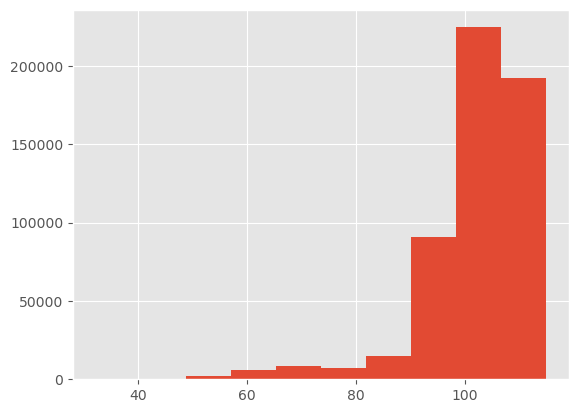

In [7]:
# Target Distrpution
df['Customer Satisfaction Score'].hist();

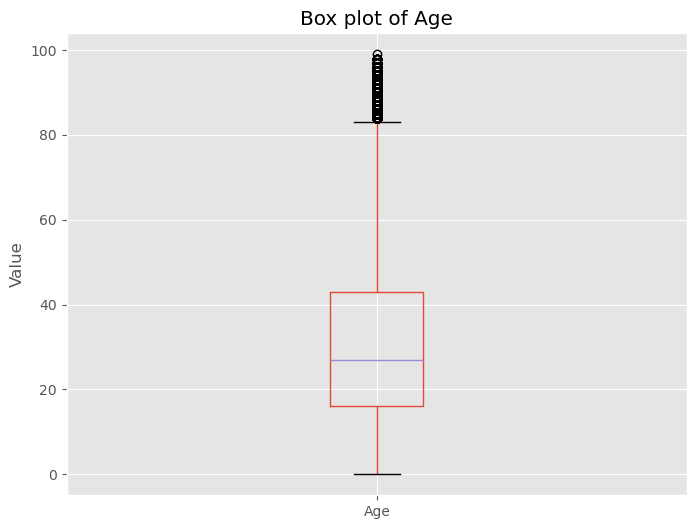

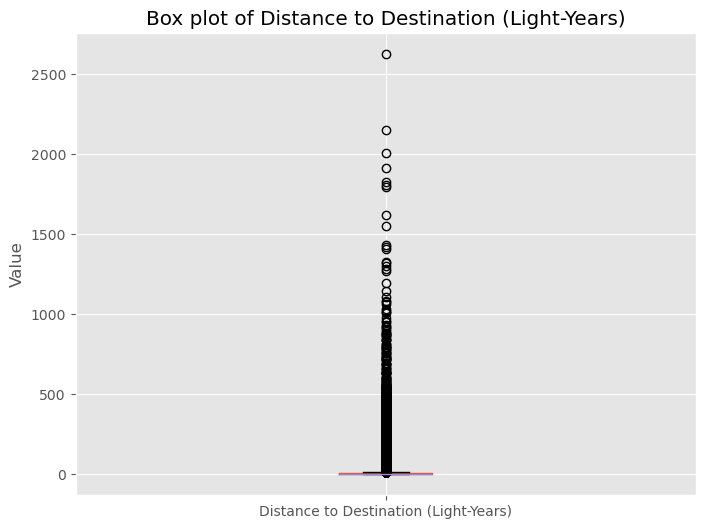

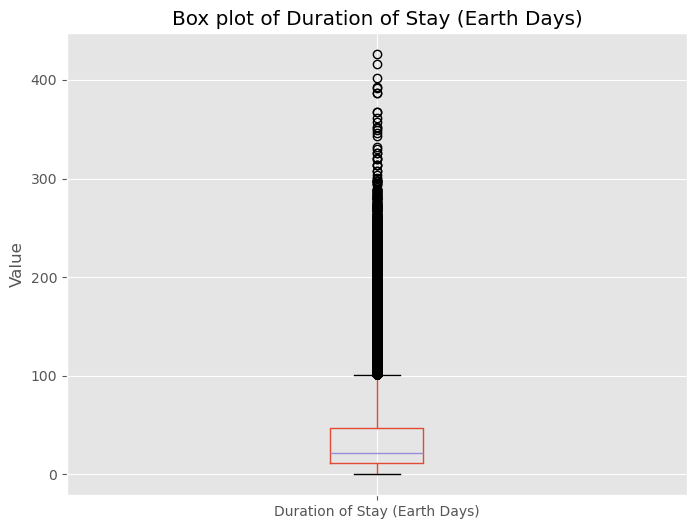

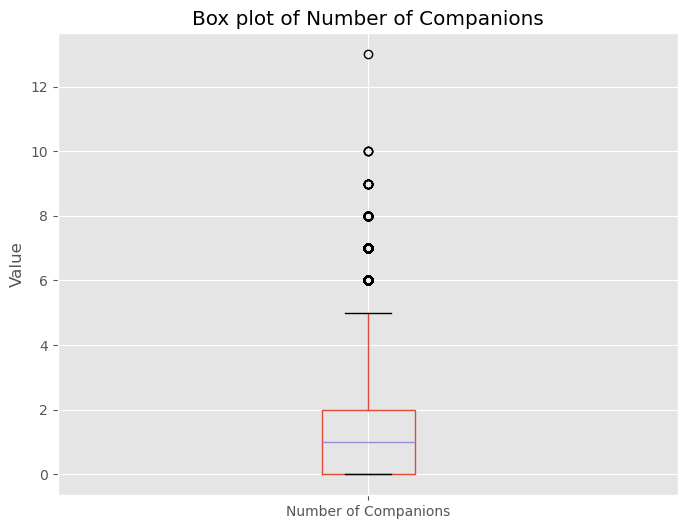

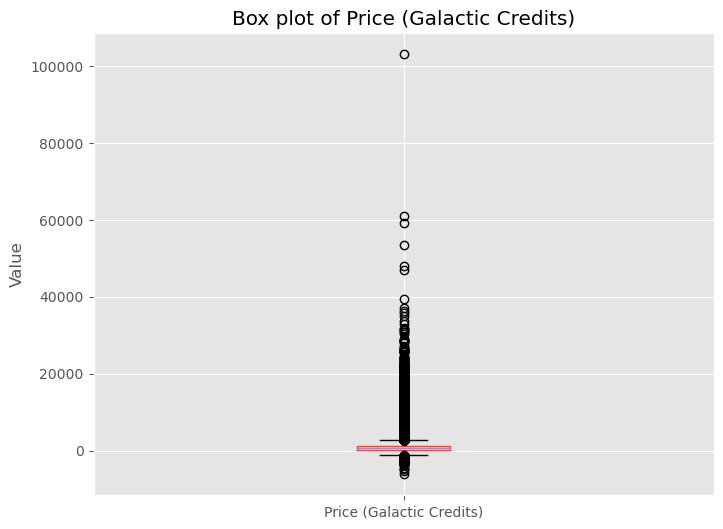

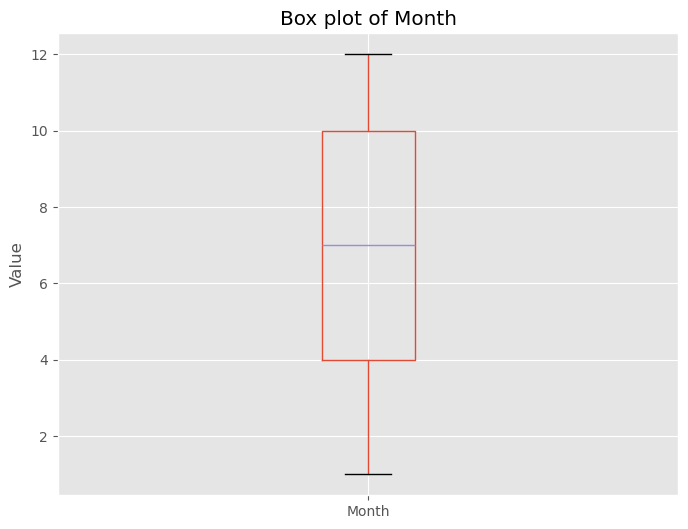

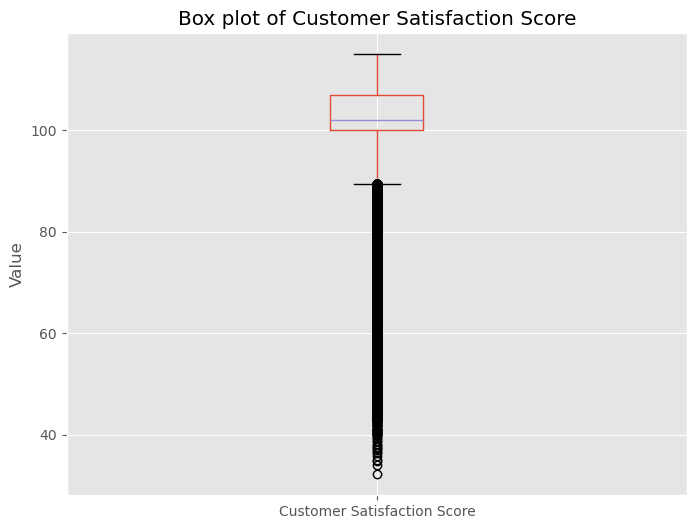

In [8]:
# Create box plots for numerical columns
for col in df.select_dtypes(include='number').columns:
    plt.figure(figsize=(8, 6))
    df.boxplot(column=col)
    plt.title(f'Box plot of {col}')
    plt.ylabel('Value')
    plt.show()

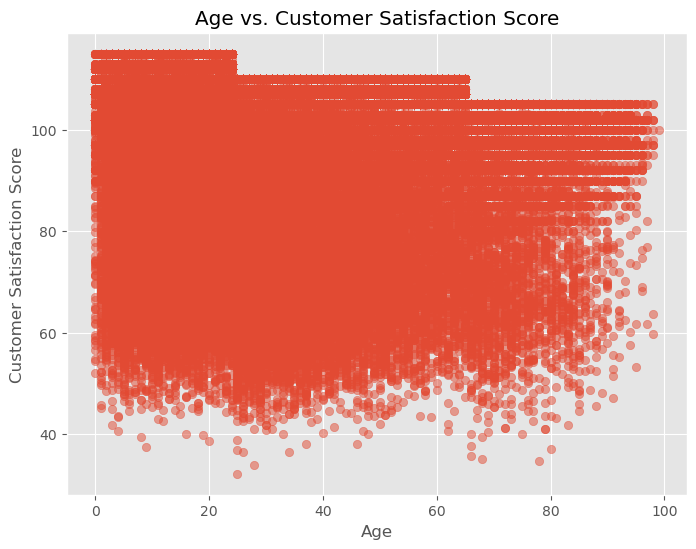

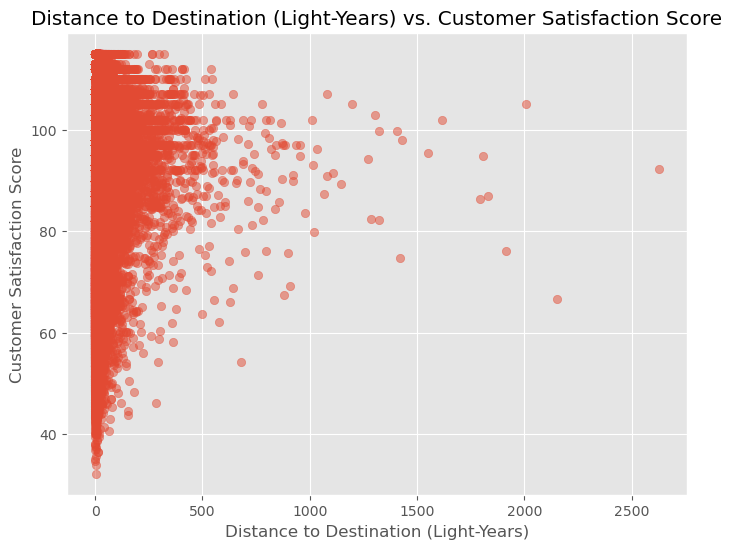

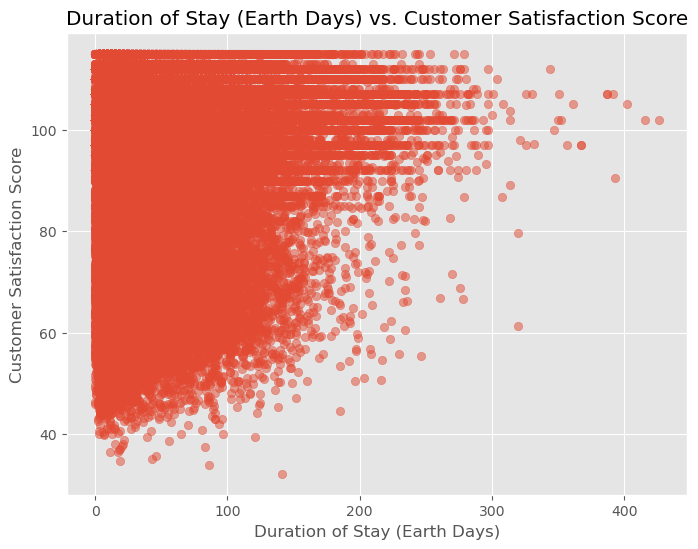

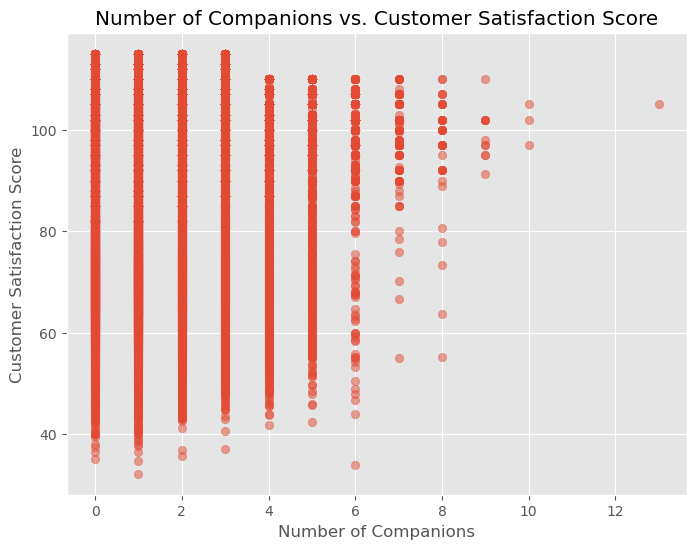

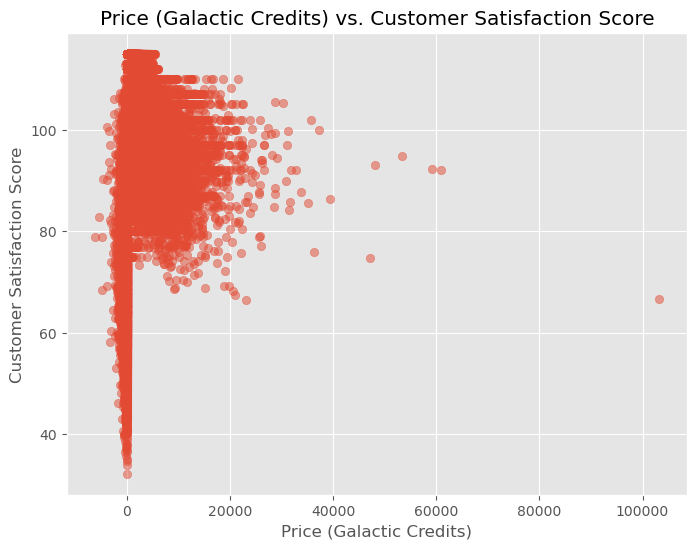

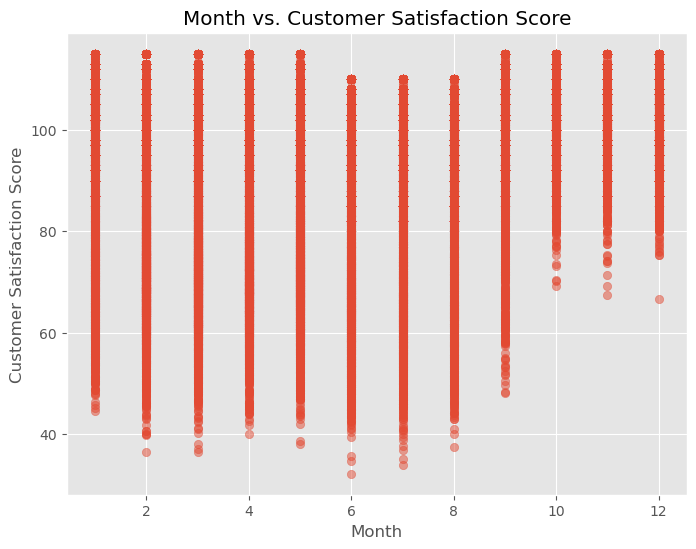

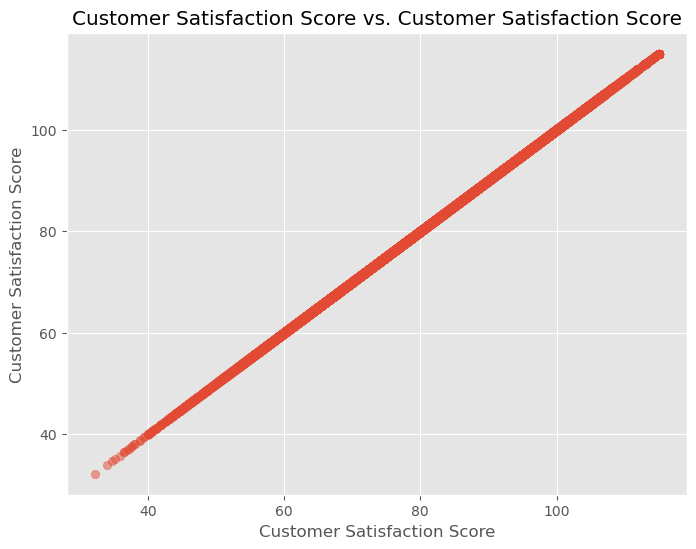

In [9]:
# Select numerical features and target variable
numerical_cols = df.select_dtypes(include='number').columns
target_col = 'Customer Satisfaction Score'

# Create scatter plots for numerical features vs. target variable
for col in numerical_cols:
    plt.figure(figsize=(8, 6))
    plt.scatter(df[col], df[target_col], alpha=0.5)
    plt.title(f'{col} vs. {target_col}')
    plt.xlabel(col)
    plt.ylabel(target_col)
    plt.grid(True)
    plt.show()

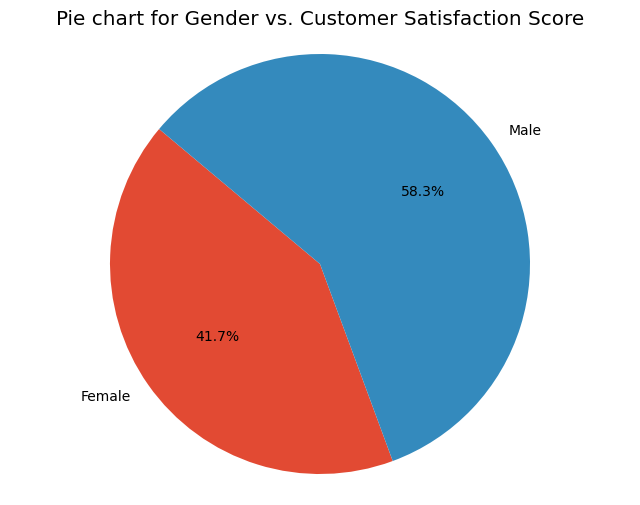

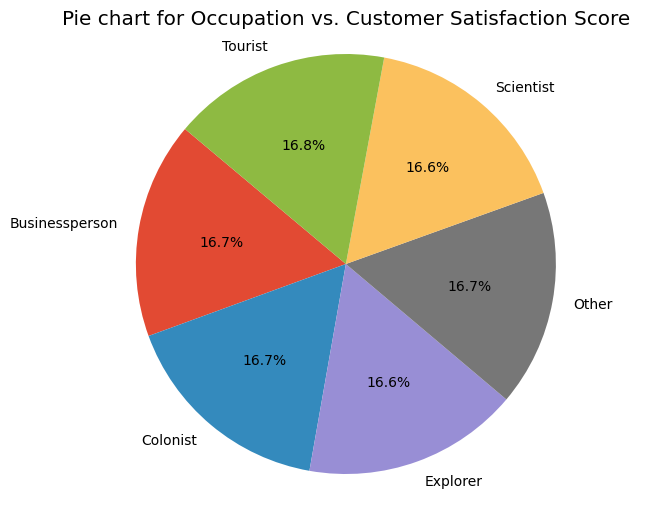

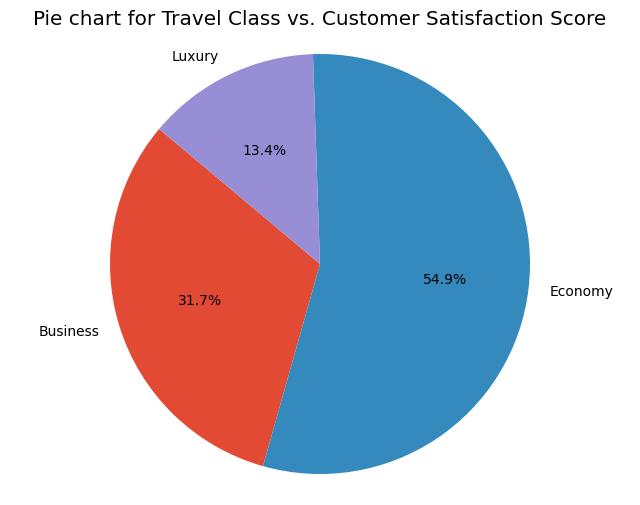

Destination has more than 10 unique values. Skipping plotting.
Star System has more than 10 unique values. Skipping plotting.


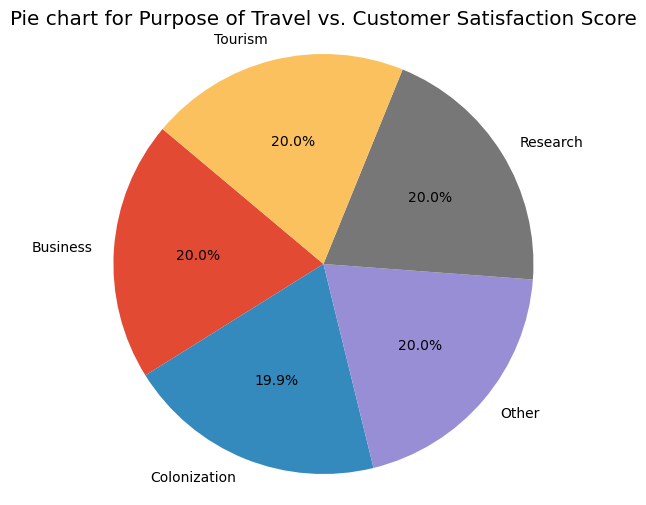

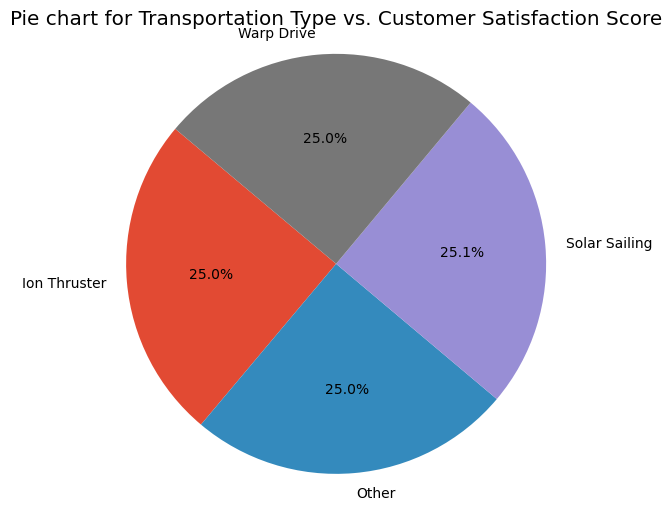

Booking Date has more than 10 unique values. Skipping plotting.
Departure Date has more than 10 unique values. Skipping plotting.


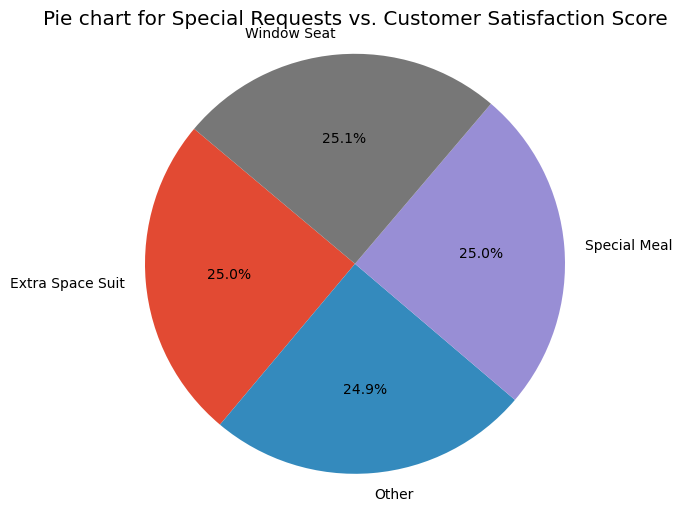

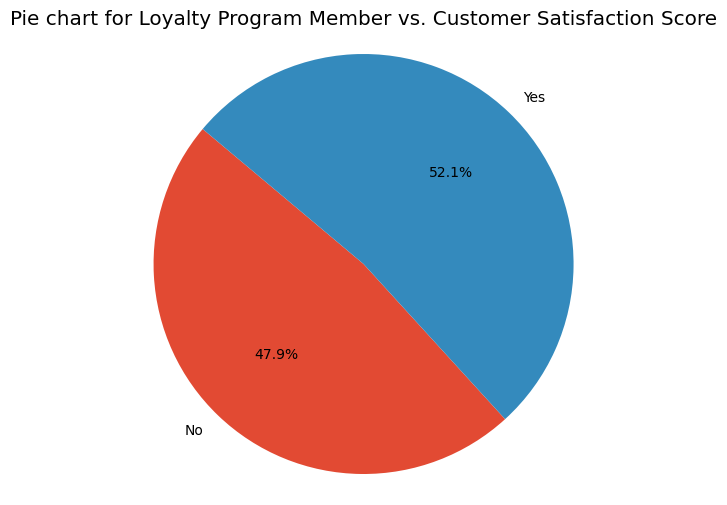

In [10]:
# Select numerical features and target variable
cols = df.select_dtypes(include='object').columns

# Create pie plots for numerical features vs. target variable
for col in cols:
    if df[col].nunique() <= 10:  # Check if the number of unique values in the column is less than or equal to 10
        # Get data for the pie chart
        groupby_data = df.groupby(col)[target_col].count()

        # Calculate percentages
        pie_data = 100 * groupby_data / groupby_data.sum()

        # Plot the pie chart
        plt.figure(figsize=(8, 6))
        plt.pie(pie_data, labels=pie_data.index, autopct='%1.1f%%', startangle=140)
        plt.title(f'Pie chart for {col} vs. {target_col}')
        plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
        plt.show()
    else:
        print(f"{col} has more than 10 unique values. Skipping plotting.")

In [11]:
!pip install optuna

In [12]:
def preprocess_data(df,columns_to_remove_outliers:list):
    
    # We Will fill The NAN falue with Other 
    df['Special Requests'] = df['Special Requests'].fillna('Other')
    print(df.shape)
    def remove_outliers(df, columns):
        df_cleaned = df.copy()
        for column in columns:
            # Calculate Z-scores
            z_scores = stats.zscore(df_cleaned[column])
            # Set a threshold (3) beyond which data points are considered outliers
            threshold = 3
            # Remove outliers
            df_cleaned = df_cleaned[(z_scores < threshold) & (z_scores > -threshold)]
        return df_cleaned
    df = remove_outliers(df, columns_to_remove_outliers)
    print(df.shape)
    
    categorical_cols = df.select_dtypes(include=['object', 'category']).columns
    
    # Initialize LabelEncoder
    label_encoder = LabelEncoder()
    
    # Apply LabelEncoder to each categorical column
    for col in categorical_cols:
        df[col] = label_encoder.fit_transform(df[col].astype(str))
    
    
    X = df.drop(columns=['Customer Satisfaction Score'])
    y = df['Customer Satisfaction Score']

    return X,y

In [13]:
X, y = preprocess_data(df, ['Age', 'Distance to Destination (Light-Years)',
       'Duration of Stay (Earth Days)', 'Number of Companions',
       'Price (Galactic Credits)', 'Customer Satisfaction Score'])

(547568, 18)
(498995, 18)


In [14]:
import optuna
import numpy as np
import pandas as pd
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

# Define objective function for Optuna
def objective(trial):
    # Define hyperparameters to search
    param = {
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 10),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 10),
    }
    
    # Initialize XGBoost regressor with the suggested parameters
    xgb = XGBRegressor(**param)
    
    # Fit the model on training data
    xgb.fit(X_train, y_train)
    
    # Predict on the validation set
    y_pred = xgb.predict(X_valid)
    
    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
    
    return rmse

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Perform hyperparameter optimization using Optuna
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=20)

# Print the best trial and parameters found
print("Best trial:")
best_trial = study.best_trial
print(f"  Value: {best_trial.value}")
print("  Params: ")
for key, value in best_trial.params.items():
    print(f"    {key}: {value}")

# Use the best parameters to train the final model
best_params = best_trial.params
xgb_best = XGBRegressor(**best_params)
xgb_best.fit(X_train, y_train)

# Make predictions on the test set
y_pred_test = xgb_best.predict(X_test)

# Calculate RMSE on the test set
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
print("Test RMSE:", rmse_test)

[I 2025-01-05 19:16:26,644] A new study created in memory with name: no-name-56ce6b04-7fae-4654-9c51-cfb402666590
[I 2025-01-05 19:16:47,548] Trial 0 finished with value: 2.883440417863378 and parameters: {'n_estimators': 489, 'max_depth': 8, 'learning_rate': 0.012456879598410003, 'subsample': 0.6706554362159134, 'colsample_bytree': 0.9512659704703801, 'reg_alpha': 9.920145757437037, 'reg_lambda': 9.074109634386296}. Best is trial 0 with value: 2.883440417863378.
[I 2025-01-05 19:17:08,392] Trial 1 finished with value: 2.8527129521516232 and parameters: {'n_estimators': 630, 'max_depth': 6, 'learning_rate': 0.07338135560648228, 'subsample': 0.9822954314597565, 'colsample_bytree': 0.6153889436266958, 'reg_alpha': 4.241033040645607, 'reg_lambda': 8.486954551510571}. Best is trial 1 with value: 2.8527129521516232.
[I 2025-01-05 19:17:44,823] Trial 2 finished with value: 2.8306533433862033 and parameters: {'n_estimators': 922, 'max_depth': 7, 'learning_rate': 0.05154333177802677, 'subsampl

Best trial:
  Value: 2.817320391123625
  Params: 
    n_estimators: 732
    max_depth: 8
    learning_rate: 0.08899373461162391
    subsample: 0.601308842568182
    colsample_bytree: 0.993650913264726
    reg_alpha: 3.390471219821716
    reg_lambda: 6.652098213518141
Test RMSE: 2.79102740978656


<Figure size 1000x600 with 0 Axes>

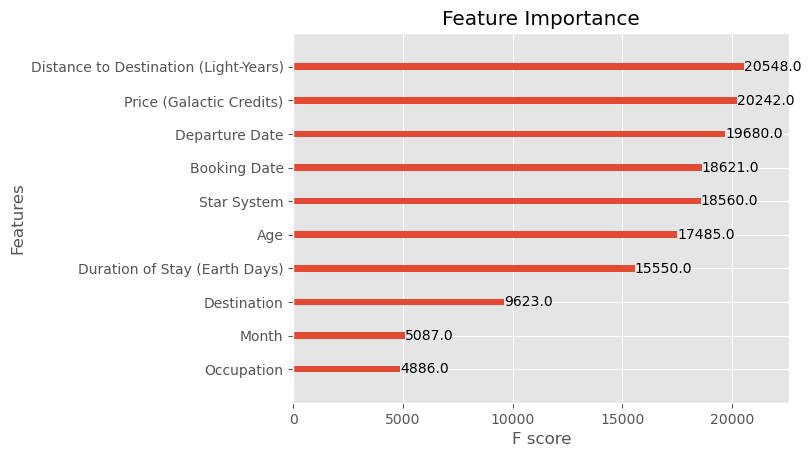

In [15]:
from xgboost import plot_importance

# Assuming xgb_best is your trained XGBoost model
# Plot feature importance
plt.figure(figsize=(10, 6))
plot_importance(xgb_best, max_num_features=10)  # Adjust max_num_features as needed
plt.title("Feature Importance")
plt.show()